In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def RemoveDownTime(hrData):
    # 5 is the warning code sent by Arduino when it has trouble receiving the hr from the PulseSensor.
    # Potential causes: PulseSensor was disconnected or the finger strap went loose, body movement, physiological, ...
    # Intersting observation: the pulse signal goes practically undetected when yawning ... or maybe I have an issue! 
    hrDataNoDt = hrData.drop(hrData.loc[hrData['hr'] == 5].index)
    # 6 is the warning code sent by the App when it has trouble acquiring hr measurements. 
    # Potential causes: the circuit was switch off, the 9V batteries ran out, the distance is too big, ...
    hrDataNoDt = hrDataNoDt.drop(hrDataNoDt.loc[hrDataNoDt['hr'] == 6].index)
    
    return hrDataNoDt

In [3]:
filename = 'bpmLog_01-04-2021 015922 AM.txt'
path = 'HRlogs/'

In [4]:
hrData = pd.read_csv(path + filename, sep = "; ", header = None, names = ["time", "hr"], engine = 'python')

In [5]:
hrData['time'] = hrData['time'].astype('datetime64[ms]')

In [6]:
hrData[:2]

,time,hr
0,2021-01-04 01:59:22,55
1,2021-01-04 01:59:23,55


In [7]:
recordingDuration = hrData['time'].max() - hrData['time'].min()
print(recordingDuration)

0 days 06:27:29


In [8]:
hrData['hr'].describe()

count    35328.000000
mean        45.889606
std          7.874934
min          0.000000
25%         44.000000
50%         46.000000
75%         48.000000
max        238.000000
Name: hr, dtype: float64

C:\Users\alain\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


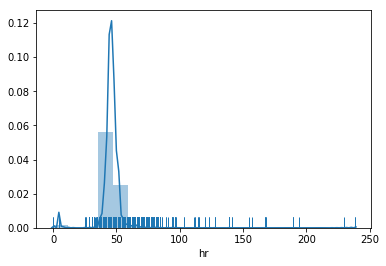

In [9]:
hrDistPlot = sns.distplot(hrData['hr'], bins = 20, kde = 'norm', rug = True, norm_hist = False)

In [10]:
figure = hrDistPlot.get_figure()    
figure.savefig("HR-DistWithDowntime.png", dpi=400)

In [11]:
hrDataNoDt = RemoveDownTime(hrData)

In [12]:
hrDataNoDt['hr'].describe()

count    34729.000000
mean        46.594863
std          5.809331
min          0.000000
25%         44.000000
50%         46.000000
75%         48.000000
max        238.000000
Name: hr, dtype: float64

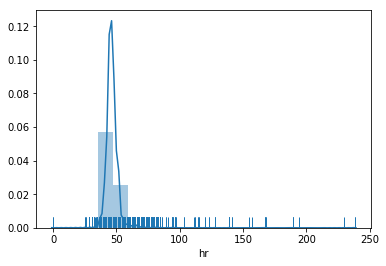

In [13]:
hrDistPlot = sns.distplot(hrDataNoDt['hr'], bins = 20, kde = 'norm', rug = True, norm_hist = False)

In [14]:
figure = hrDistPlot.get_figure()    
figure.savefig("HR-DistWithoutDowntime.png", dpi=400)

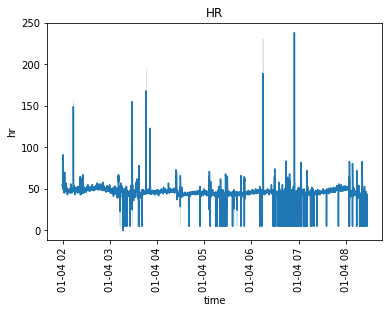

In [15]:
sns.lineplot(x="time", y="hr", data=hrData)
plt.xticks(rotation=90)
plt.title('HR')
plt.savefig("HR-LogstWithDowntime.png", dpi=400)
plt.show()

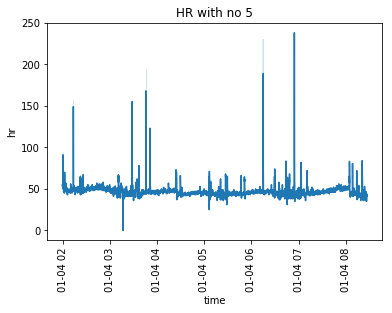

In [16]:
sns.lineplot(x="time", y="hr", data=hrDataNoDt)
plt.xticks(rotation=90)
plt.title('HR with no 5')
plt.savefig("HR-LogstWithoutDowntime.png", dpi=400)
plt.show()

### Analysis of the events when Arduino had trouble acquiring the HR

In [17]:
# Pourcentage of downtime (Dt)
pourcentDt = 100 * (hrData.loc[hrData['hr'] == 5].shape[0] / hrData.shape[0])
print(pourcentDt)

1.6955389492753623


In [18]:
# Mark the transitions from something to 5
hrData['to5'] = hrData['hr'].rolling(2).apply(lambda x: x[0] != x[-1] and x[-1] == 5, raw = True)
# Mark the transitions from 5 to something
hrData['from5'] = hrData['hr'].rolling(2).apply(lambda x: x[0] != x[-1] and x[0] == 5, raw = True)

In [19]:
# Special case when first recording is 5
if hrData.loc[0, 'hr'] == 5:
    hrData.loc[0, 'to5'] = 1
    hrData.loc[0, 'from5'] = 0
else:
    hrData.loc[0, 'to5'] = 0
    hrData.loc[0, 'from5'] = 0

In [20]:
hrData[:3]

,time,hr,to5,from5
0,2021-01-04 01:59:22,55,0.0,0.0
1,2021-01-04 01:59:23,55,0.0,0.0
2,2021-01-04 01:59:24,55,0.0,0.0


In [21]:
# Number of events when Arduino fails reading HR
nbrBreak = hrData['to5'].sum()
print(nbrBreak)

115.0


In [22]:
hrData[:3]

,time,hr,to5,from5
0,2021-01-04 01:59:22,55,0.0,0.0
1,2021-01-04 01:59:23,55,0.0,0.0
2,2021-01-04 01:59:24,55,0.0,0.0


In [23]:
hrLowerTh = 30 # HR lower threshold
hrUpperTh = 100 # HR higher threshold

In [24]:
# Mark the transitions through the lower threshold 
hrData['ThroughLowerTh'] = hrData['hr'].rolling(2).apply(lambda x: x[0] > hrLowerTh and x[-1] <= hrLowerTh and x[-1] != (5 or 6), raw = True)
print("Number of transitions through the lower threshold = ", hrData['ThroughLowerTh'].sum())
# Mark the transitions through the upper threshold
hrData['ThroughUpperTh'] = hrData['hr'].rolling(2).apply(lambda x: x[0] < hrUpperTh and x[-1] >= hrUpperTh and x[-1] != (5 or 6), raw = True)
print("Number of transitions through the upper threshold = ", hrData['ThroughUpperTh'].sum())
# Fill first row
hrData.loc[0, 'ThroughLowerTh'] = hrData.loc[0, 'ThroughUpperTh'] = 0

Number of transitions through the lower threshold =  2.0
Number of transitions through the upper threshold =  6.0


In [25]:
hrData.to_excel('hrAnalysis.xlsx', index = False)

In [26]:
# Compute how long is each downtime triggered by Arduino

In [27]:
breakList = []

In [28]:
for i in range(0, hrData.shape[0]):
    if hrData.loc[i, 'to5'] == 1:
        for j in range(i, hrData.shape[0]):
            if hrData.loc[j, 'from5'] == 1:
                breakList.append((hrData.loc[j, 'time'] - hrData.loc[i, 'time']).total_seconds())
                i = j
                break;

In [29]:
# Transform the list of breaks into a DataFrame 
breakDF = pd.DataFrame({'downTime':breakList})

In [30]:
breakDF[:3]

,downTime
0,1.0
1,2.0
2,1.0


In [31]:
breakDF.describe()

,downTime
count,115.000000
mean,3.573913
std,3.220169
min,0.000000
25%,2.000000
50%,2.000000
75%,5.000000
max,18.000000


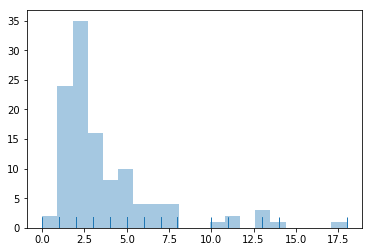

In [32]:
dtDistPlot = sns.distplot(breakDF, bins = 20, kde = False, rug = True, norm_hist = False)

In [33]:
figure = dtDistPlot.get_figure()    
figure.savefig("DowntimeHistogram.png", dpi=400)

In [34]:
# Was any downtime event triggered by the App side
hrData.loc[hrData['hr'] == 6].count()

time              0
hr                0
to5               0
from5             0
ThroughLowerTh    0
ThroughUpperTh    0
dtype: int64